In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from numpy import cov
from sklearn.utils import shuffle
import numpy as nps

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from nltk.corpus import stopwords

In [2]:
data = {}
unzipped = gzip.open('Beeradvocate.txt.gz', 'rb')

ind = 0
currdat = {}
with unzipped as f:
    for line in f:
        clean = line.decode('utf-8')
        clean = clean.replace('\t', '')
        splitted = clean.replace('\n', '').split(':')

        if (len(splitted) == 1):
            data[f"{ind}"] = currdat
            currdat = {}
            ind = ind + 1
        
        else:
            currdat[f"{splitted[0]}"] = splitted[1].strip()

df= pd.DataFrame(data).transpose()

In [3]:
df.head()

,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/profileName,review/taste,review/text,review/time
0,5.00,47986,10325,Sausa Weizen,Hefeweizen,2.5,2,1.5,1.5,stcules,1.5,A lot of foam. But a lot.In the smell some ban...,1234817823
1,6.20,48213,10325,Red Moon,English Strong Ale,3,2.5,3,3,stcules,3,"Dark red color, light beige foam, average.In t...",1235915097
2,6.50,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3,2.5,3,3,stcules,3,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.00,47969,10325,Sausa Pils,German Pilsener,3.5,3,3,2.5,stcules,3,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.70,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4,4.5,4,4,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [4]:
df = df[df['beer/ABV'] != '']
df.shape
df = shuffle(df)

(1518829, 13)

In [16]:
# use only the first 200000 data points from the dataset
beer_dat = df.copy()[:200000]
beer_dat.shape

(200000, 13)

In [17]:
# check the number of unique styles of beer
print(len(df['beer/style'].unique()))
print(len(beer_dat['beer/style'].unique()))

104
104


In [18]:
beer_dat['review/appearance'] = beer_dat['review/appearance'].apply(float)
beer_dat['review/aroma'] = beer_dat['review/aroma'].apply(float)
beer_dat['review/overall'] = beer_dat['review/overall'].apply(float)
beer_dat['review/palate'] = beer_dat['review/palate'].apply(float)
beer_dat['review/taste'] = beer_dat['review/taste'].apply(float)
beer_dat['beer/ABV'] = beer_dat['beer/ABV'].apply(float)

In [19]:
beer_dat = beer_dat.rename(columns={'review/appearance': 'Appearance', 'review/aroma': 'Aroma', 'review/overall':'Overall',
                  'review/palate':'Palate', 'review/taste':'Taste', 'beer/ABV':'ABV'})

## Part 1: Exploratory Analysis on Beer Dataset

In [20]:
beer_dat[:5]

,ABV,beer/beerId,beer/brewerId,beer/name,beer/style,Appearance,Aroma,Overall,Palate,review/profileName,Taste,review/text,review/time
396193,8.8,1115,389,Lion Stout,Foreign / Export Stout,3.0,4.0,4.5,3.5,mrasskicktastic,4.0,A - Black with a creamy one and a half finger ...,1158441784
1576129,5.5,11280,4701,Yukon Red Amber Ale (Arctic Red),American Amber / Red Ale,4.0,4.0,4.5,4.0,wordemupg,4.5,341ml bottle poured into pint glass dec29 2009...,1262140075
1034797,5.1,132,39,Ayinger Bräu Weisse,Hefeweizen,4.5,4.0,4.5,4.0,Stagi,4.0,500ml bottle.A very cloudy yellow with a good ...,1192575974
1309276,5.0,65,29,Budweiser,American Adjunct Lager,1.5,2.5,2.5,2.5,Happyhour,1.5,I cant even describe what this color is... its...,1076826438
1483420,5.5,13042,3465,Spécial De Ryck,Belgian Pale Ale,4.0,3.5,4.0,3.0,TheLongBeachBum,3.5,Sampled in the on-site Old Stables Tasting Roo...,1113888860


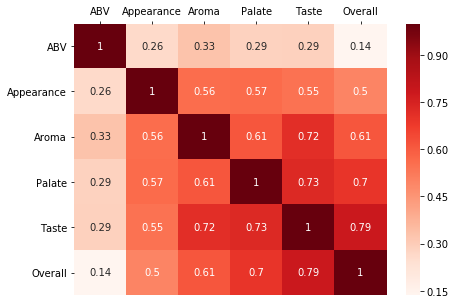

In [37]:
plt.figure(figsize=(7, 5))
beercor = beer_dat[['ABV', 'Appearance', 'Aroma', 'Palate', 'Taste', 'Overall']].corr()
ax = sns.heatmap(beercor, annot=True, cmap=plt.cm.Reds) 
ax.xaxis.set_ticks_position('top')
loc, labels = plt.yticks() 
ax.set_yticklabels(labels, rotation=0)
plt.show()

In [97]:
print("The beer-review dataset contains " + str(len(beer_dat['beer/style'].unique())) + " unique types of beer\n")
print("Here are 5 most-reviewed types of beer: ")
top_5_beer = beer_dat['beer/style'].value_counts().head(10).to_frame() 
top_5_beer.columns = ['NUMBER OF REVIEWS']
top_5_beer

The beer-review dataset contains 104 unique types of beer

Here are 5 most-reviewed types of beer: 


,NUMBER OF REVIEWS
American IPA,14965
American Double / Imperial IPA,11303
American Pale Ale (APA),7642
Russian Imperial Stout,7067
American Double / Imperial Stout,6672
American Porter,6120
American Amber / Red Ale,5507
Belgian Strong Dark Ale,5037
American Strong Ale,4165
Fruit / Vegetable Beer,4157


In [96]:
sum(top_5_beer['NUMBER OF REVIEWS'])

47649

In [39]:
to_contain = 'American Double / Imperial Stout|American IPA|American Double / Imperial IPA|American Pale Ale \(APA\)|American Porter'
df_top_5 = beer_dat[beer_dat['beer/style'].str.contains(to_contain , na=False)]

In [41]:
df_top_5 = df_top_5.sort_values(by=['beer/style']) 
df_top_5 = df_top_5.reset_index() 
df_top_5.drop('index', axis=1, inplace=True)

beer_styles = ['American Double / Imperial Stout', 'American IPA', 'American Double / Imperial IPA','American Pale Ale (APA)','American Porter']
beer_ratings = [0,0,0,0,0]
appearance_rating_dict = dict(zip(beer_styles,beer_ratings)) 
palate_rating_dict = dict(zip(beer_styles,beer_ratings)) 
aroma_rating_dict = dict(zip(beer_styles,beer_ratings)) 
taste_rating_dict = dict(zip(beer_styles,beer_ratings)) 
overall_rating_dict = dict(zip(beer_styles,beer_ratings))

for style in beer_styles:
    appearance_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['Appearance'].mean(),2) 
    palate_rating_dict[style] = round(df_top_5[df_top_5['beer/style']== style]['Palate'].mean(),2)
    aroma_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['Aroma'].mean(),2)
    taste_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['Taste'].mean(),2)
    overall_rating_dict[style] = round(df_top_5[df_top_5['beer/style']== style]['Overall'].mean(),2)
    
appearance_rating_df = pd.Series(appearance_rating_dict).to_frame() 
palate_rating_df = pd.Series(palate_rating_dict).to_frame() 
aroma_rating_df = pd.Series(aroma_rating_dict).to_frame() 
taste_rating_df = pd.Series(taste_rating_dict).to_frame() 
overall_rating_df = pd.Series(overall_rating_dict).to_frame()

In [42]:
appearance_rating_df.columns = ['Appearance Rating'] 
palate_rating_df.columns = ['Palate Rating'] 
aroma_rating_df.columns = ['Aroma Rating'] 
taste_rating_df.columns = ['Taste Rating'] 
overall_rating_df.columns = ['Overall Rating']

ratings_df = pd.concat([appearance_rating_df, palate_rating_df], axis= 1, join='inner')
ratings_df = pd.concat([ratings_df, aroma_rating_df], axis=1, join='inner')
ratings_df = pd.concat([ratings_df, taste_rating_df], axis=1, join='inner')
ratings_df = pd.concat([ratings_df, overall_rating_df], axis=1, join='inner')

print("\nAn Overview of the Ratings for the 5 Most-reviewed Beer Types ")
#The dataframe that contains all the individual ratings ratings_df ## THIS CONTAINS THE AVERAGE RATINGS

ratings_df


An Overview of the Ratings for the 5 Most-reviewed Beer Types 


,Appearance Rating,Palate Rating,Aroma Rating,Taste Rating,Overall Rating
American Double / Imperial Stout,4.16,4.11,4.16,4.19,4.03
American IPA,3.98,3.87,3.90,3.93,3.97
American Double / Imperial IPA,4.08,4.03,4.11,4.10,3.99
American Pale Ale (APA),3.79,3.70,3.68,3.74,3.86
American Porter,3.95,3.80,3.84,3.91,3.91


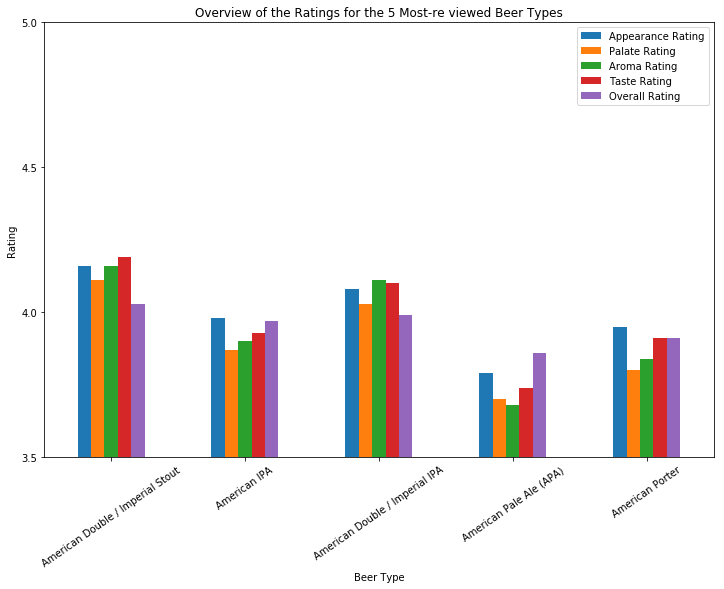

In [43]:
ratings_df.plot.bar(title = 'Overview of the Ratings for the 5 Most-re viewed Beer Types',figsize= (12,8))
labels = [3.5, 4.0, 4.5, 5.0]
plt.yticks(labels)
plt.ylim(3.5,5) 
plt.xticks(rotation = 35) 
plt.xlabel("Beer Type") 
plt.ylabel("Rating") 
plt.show()

## Observation:
From the bar chart above, we can see that "American Double/Imperial Stout" is the beer type that receives the highest review in all categories (appearance, palate, aroma, taste and overall)

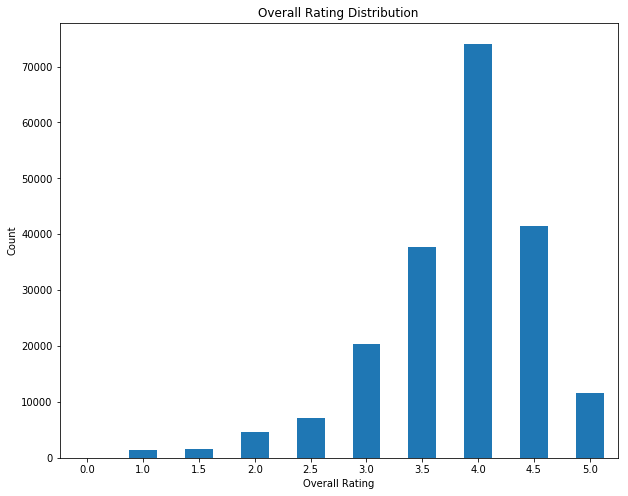

In [63]:
beer_dat['Overall'].value_counts().sort_index().plot('bar',title = 'Overall Rating Distribution',figsize= (10,8), color='#1f77b4')
plt.xticks(rotation = 0)
plt.xlabel("Overall Rating")
plt.ylabel("Count") 
plt.show()

In [75]:
sortedlist = beer_dat['Overall'].value_counts().sort_index(ascending=False)

In [94]:
print(sortedlist)
print(sortedlist.tolist())
print(sum(sortedlist.tolist()[:3]))
ratingdist = pd.DataFrame(sortedlist)
ratingdist

5.0    11615
4.5    41555
4.0    74095
3.5    37686
3.0    20312
2.5     7173
2.0     4636
1.5     1564
1.0     1362
0.0        2
Name: Overall, dtype: int64
[11615, 41555, 74095, 37686, 20312, 7173, 4636, 1564, 1362, 2]
127265


,Overall
5.0,11615
4.5,41555
4.0,74095
3.5,37686
3.0,20312
2.5,7173
2.0,4636
1.5,1564
1.0,1362
0.0,2


## Observation:
From the bar chart above, we can see that people tend to give an overall rating of 4.0 for the 5 most-popular beer styles. This means that the most-reviewed beers also tend to receive a relatively high overall rating.

In [48]:
df_top_5 = df_top_5[['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall']]
data = df_top_5.sample(frac=1) ## random shuffle the dataframe ( not in place)

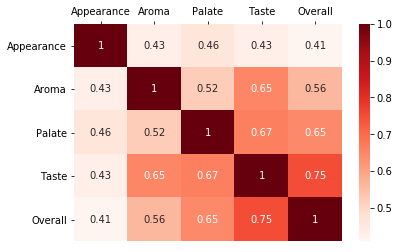

In [49]:
#Using Pearson Correlation plt.figure(figsize=(10,10))
cor = data.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) 
ax.xaxis.set_ticks_position('top')
loc, labels = plt.yticks() 
ax.set_yticklabels(labels, rotation=0)
plt.show()

## OBSERVATION:
Based on the correlation matrix above, we can see that taste correlates the most (corr = 0.72) with the overall beer rating, meaning that taste is the most important feature of a beer.

## Part 2: Predictive Task

### Predicting Overall Beer Rating from Taste, Appearance, Aroma and Palate Ratings

- Data is split into train and test set (80:20 ratio)

- Using the ratings for the four features (taste, appearance, aroma and palate), we will use first use linear regression to predict the overall rating for each beer style. This will serve as the baseline predictor that we will improve upon

In [52]:
#beer_dat = shuffle(beer_dat)

#train-test split
train_size = int(len(beer_dat)*float(0.5))
valid_size = int(len(beer_dat)*float(0.25))
test_size = int(len(beer_dat)*float(0.25))
                 
trainX = beer_dat[:train_size]
trainY = beer_dat['Overall'][:train_size] 

validX = beer_dat[train_size:train_size + valid_size]
validY = beer_dat['Overall'][train_size:train_size + valid_size]

testX = beer_dat[(train_size + valid_size):(train_size + valid_size + test_size)] 
testY = beer_dat['Overall'][(train_size + valid_size):(train_size + valid_size + test_size)]         

print(len(trainX), len(validX), len(testX))

100000 50000 50000


In [53]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features=3000, stop_words=stopwords.words('english'))

# compute tfidf with training set and get values for training set
fitted_vectorizer=tfidf_vectorizer.fit(trainX['review/text'].tolist())
tfidf_vectorizer_train=fitted_vectorizer.transform(trainX['review/text'].tolist())

# values for validation set
tfidf_vectorizer_valid=fitted_vectorizer.transform(validX['review/text'].tolist())

In [57]:
# Create dictionary of top five beers to use for one hot encoding
topfive = trainX['beer/style'].value_counts().index[:5]
fivedict = dict(zip(topfive, [0, 1, 2, 3, 4]))

def pick_feature(datum): 
    feat=[1]
    feat.append( datum['Taste']) 
    feat.append( datum['Palate']) 
    feat.append( datum['Aroma']) 
    feat.append( datum['Appearance'])
    
    
    # one hot encoding for top 5 beer styles
    empty = [0, 0, 0, 0, 0]
    style = datum['beer/style']
    if (style in topfive):
        empty[fivedict[style]] = 1
        
    feat.extend(empty)
    
    return feat

In [58]:
# Create training feature matrix
train_feat = []
for index, row in trainX.iterrows():
    train_feat.append(pick_feature(row))
    
# Create valid feature matrix
valid_feat = []
for index, row in validX.iterrows():
    valid_feat.append(pick_feature(row))

In [59]:
traincomp = csr_matrix(train_feat)
validcomp = csr_matrix(valid_feat)

In [60]:
finaltrain = sp.hstack((traincomp, tfidf_vectorizer_train))
finalvalid = sp.hstack((validcomp, tfidf_vectorizer_valid))

In [61]:
model = LinearRegression()
model.fit(finaltrain, trainY)


train_pred = model.predict(finaltrain)
#Returns the coefficient of determination R^2 of the prediction.
print(model.score(finaltrain, trainY))
# Print MSE and MAE to compare
print(mean_squared_error(trainY, train_pred))
print(mean_absolute_error(trainY, train_pred))

print('\n')


valid_pred = model.predict(finalvalid)
#Returns the coefficient of determination R^2 of the prediction.
print(model.score(finalvalid, validY))
# Print MSE and MAE to compare
print(mean_squared_error(validY, valid_pred))
print(mean_absolute_error(validY, valid_pred))

0.6976073400154886
0.15385862493787195
0.2967854134099274


0.6835126321501688
0.1644505126203885
0.3069369996017707


r2, mse, mae using all four scores and one hot top five beers
<br>
0.6615898250522957
<br>
0.17583554419062639
<br>
0.3127927941938682
<br>

0.6583456872393458
<br>
0.1791718975746533
<br>
0.31451956772621104

r2, mse, mae using all four scores and one hot of top five and tfidf, 3000 max feat
<br>
0.7041355990322207
<br>
0.1534369609523251
<br>
0.2966299324444182
<br>

0.688296119645765
<br>
0.1646032266072723
<br>
0.3072544148057153
<br>

In [ ]:
#after predicting the overall beer rating, decide a threshold to calculate accuracy of beer prediction
# ?!!!!!!!!
# smaller than THRESHOLD === accurate prediction
# for now, set threshold to be 0.4, given ratings range from 0 - 5

threshold = 0.4
diff = abs(testY - valid_pred)
sum(diff <= threshold)/len(diff)

In [ ]:
diff